In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%matplotlib inline
# Project Helper Files
from constants import *
from plotting_helper_functions import calculate_likelyhood_comparisons, plot_measure_accross_all_demographics
# calculate_likelyhood_comparisons

SyntaxError: invalid syntax (plotting_helper_functions.py, line 14)

In [3]:
import platform
 
print(platform.python_version())

3.5.2


# Quantifying the *School To Prison Pipeline* -- a high level analysis of discipline-based inequities America's Public Schools

## Introduction

America's 96,000 public schools provide the foundation for the next generation's education and, ultimately, future success.

Yet, educational researchers and practitioners worry that America's public schools do not provide all students equal opportunity for future success. 

Some stakeholders feel the inequitable treatment of students is so severe -- particularly poor and minority students -- they've coined the term *School to Prison Pipeline*. That is, __some schools and students are pushed, not to success, but towards the criminal justice system.__ 

## Overview of Investigation Foci

This analysis' following 3 questions will center on exploring this prominent and debated concept of "The School to Prison Pipeline" in US schools, generally defined as *the disproportionate tendency of minors and young adults from disadvantaged backgrounds to become incarcerated, because of increasingly harsh school and municipal policies.*

Discussions of "The School to Prison Pipeline" and its causes largely center on a few interrelated factors:
1. __Disproportionate suspensions__, particularly towards black and disabled students.
2. __Police Presence on campus__, especially in contrast to lack of counselors and mental health professionals, meaning troubled students may be more likely to be received by *law enforcement* than counselors who are trained in helping students cope, reform, and stay in school.
3. __"Zero tolerance" policies in schools increasing suspension and expulsion rates__ as schools deliver harsh discipline for even first-time or relatively minor offenses in an aim to stop disruptive behavior before it gets worse.

We'll explore these key factors via desegregated data on all 96,000 US public schools from the 2016/15 school year CRDC data. Because revealing causality in these factors is impossible to determine given just this data, __this investigation centers on the extent and nature of these key measures at a national level__.

# Overview of the Dataset
## The Civil Rights Data Collection, school-level data for 2015-2016

The Civil Rights Data Collection (CRDC) is a biennial survey required by the U.S. Department of Education’s (Department) Office for Civil Rights (OCR) since 1968. (Note, however, that survey content changes over time.)

The 2015–16 CRDC (the most recent year published) collects data from all public local educational agencies (LEAs, ie *School Districts*) and schools, including 
- long-term secure juvenile justice facilities
- charter schools
- alternative schools
- and schools serving students with disabilities

with a response rate of 99.8% from __17,337 LEAs and 96,360 schools__. Specifically, I will be looking at the finer-grained *data disaggregated by school*.

### Data content and format
Each school (row) in the dataset includes 1,800 columns (typically a student count disaggregated by race and gender for some school measure) regarding 32 general topics, comprising a 460 MB csv. __The topics I will investigate utilize only 50 columns pertaining to suspensions, expulsions, and school population. I will only look at white, black, and hispanic students,__ who form the majority of students at nearly all schools.


### Known issues with dataset
- From the CRDC report: *"An important consideration for response rates is that the reporting process requires all schools and LEAs to respond to each survey item on the CRDC. Some LEAs, that did not have complete data, __reported a zero value__. It is not possible to determine all possible situations where this may have occurred. As such, it may be the case that the item response rates may be positively biased. For the large majority of CRDC survey items, __the rate of missing data ranged from 0-5% of reported values__."*
- In the separate __Data Prep notebook__, IDs in the original dataset greater than 10 significant digits had been cast to scientific notation format and stored as strings. __I recreated the IDs__ for those, which are a combination of State, local, and school identifiers.
- CRDC does not provide Lat Long coordinates, so [I merged in school Lat Longs from the National Center for Educational Statistics](https://nces.ed.gov/programs/edge/Geographic/SchoolLocations) in the Data Prep notebook. When schools did not have lat-long coordinates available, I assigned them the coordinate of their school district (LEA) office.

## Intro: Summary Statistics and Exploration

## Load All Schools Data (after downlaoding)
[Find this data in this Google Drive Folder.](https://drive.google.com/file/d/1LVRwFWpevvqGvMLlNt95BXmLVmBXfG0a/view?usp=sharing)

In [6]:
DATA_FILE = 'data (download CSVs here)/crdc-data-with-lat-long.csv'
crdc_data = pd.read_csv(
    DATA_FILE,
    usecols=COLS_WITH_NEEDED_DATA,
    low_memory=False,
    encoding="ISO-8859-1"
)
crdc_data

['SCH_DISCWODIS_MULTOOS_HI_M',
 'SCH_DISCWODIS_MULTOOS_HI_F',
 'SCH_DISCWODIS_MULTOOS_BL_M',
 'SCH_DISCWODIS_MULTOOS_BL_F',
 'SCH_DISCWODIS_MULTOOS_WH_M',
 'SCH_DISCWODIS_MULTOOS_WH_F',
 'TOT_DISCWODIS_MULTOOS_M',
 'TOT_DISCWODIS_MULTOOS_F',
 'SCH_ENR_HI_M',
 'SCH_ENR_HI_F',
 'SCH_ENR_BL_M',
 'SCH_ENR_BL_F',
 'SCH_ENR_WH_M',
 'SCH_ENR_WH_F',
 'TOT_ENR_M',
 'TOT_ENR_F',
 'SCH_DISCWODIS_EXPZT_HI_M',
 'SCH_DISCWODIS_EXPZT_HI_F',
 'SCH_DISCWODIS_EXPZT_BL_M',
 'SCH_DISCWODIS_EXPZT_BL_F',
 'SCH_DISCWODIS_EXPZT_WH_M',
 'SCH_DISCWODIS_EXPZT_WH_F',
 'TOT_DISCWODIS_EXPZT_F',
 'TOT_DISCWODIS_EXPZT_M',
 'SCH_DISCWODIS_EXPWE_HI_M',
 'SCH_DISCWODIS_EXPWE_HI_F',
 'SCH_DISCWODIS_EXPWE_BL_M',
 'SCH_DISCWODIS_EXPWE_BL_F',
 'SCH_DISCWODIS_EXPWE_WH_M',
 'SCH_DISCWODIS_EXPWE_WH_F',
 'TOT_DISCWODIS_EXPWE_F',
 'TOT_DISCWODIS_EXPWE_M',
 'SCH_DISCWODIS_EXPWOE_HI_M',
 'SCH_DISCWODIS_EXPWOE_HI_F',
 'SCH_DISCWODIS_EXPWOE_BL_M',
 'SCH_DISCWODIS_EXPWOE_BL_F',
 'SCH_DISCWODIS_EXPWOE_WH_M',
 'SCH_DISCWODIS_EXPWOE_WH_

### Geographic distribution of all schools
Note Alaska and Hawaii faintly on the left.

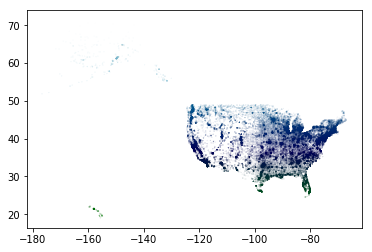

In [5]:
plt.scatter(x=crdc_data['LON1516'], y=crdc_data['LAT1516'], c=crdc_data['LAT1516'], s=0.001, cmap='ocean')
plt.show()

# Analytic Questions

# Question 1: How disproportionate are suspensions across race and gender?

#### (Apply any high-level filters as needed)

In [7]:
df = crdc_data[crdc_data['LEA_STATE_NAME'] == 'CALIFORNIA']

### What percentage of each demographic population recieve suspensions?

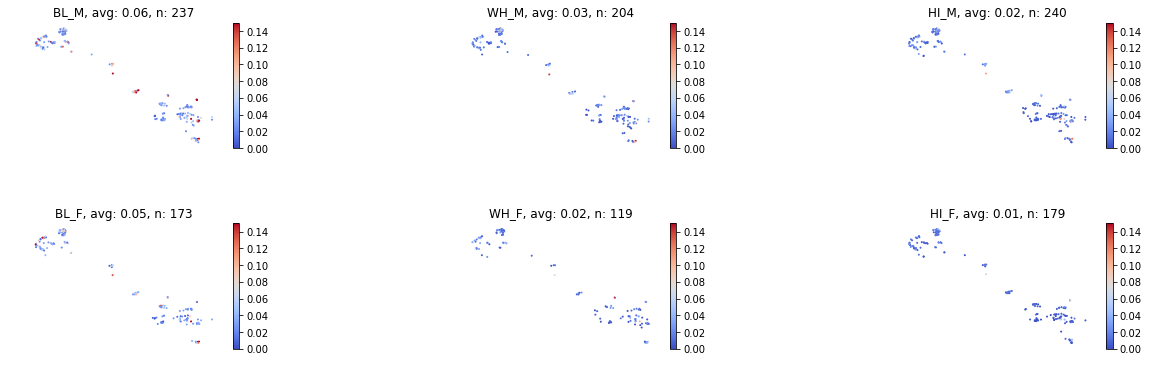

In [8]:
data = calculate_likelyhood_comparisons(df, 'SCH_DISCWODIS_MULTOOS')  # "more than one out of school suspension"
calculation = 'PERCENT_AFFECTED' 
measure = 'SCH_DISCWODIS_MULTOOS'
plot_measure_accross_all_demographics(data, calculation, measure, bounds=[0, 0.15])

# feedback: try bar charts, comparing regions/states
# Look into how you're filtering threshhodl for pop might affect. T ry looking at bigger szmples, like district

### How many times more likely to be suspended are blank and latino students than white students?
For the above "percent of population affected" plots, it's near impossible to compare the severity *across a single school*. One way to zero on on this is to color schools by *how much more likely* a certain population is to be affeced __compared to the least affected population__. This measure might reveal schools where, even if a demogrpahic is severely affected, so were other demographics.

How likelyhood comparisons are calculated: 

`Percent of X pop affected / Percent of White counterpart population affected`

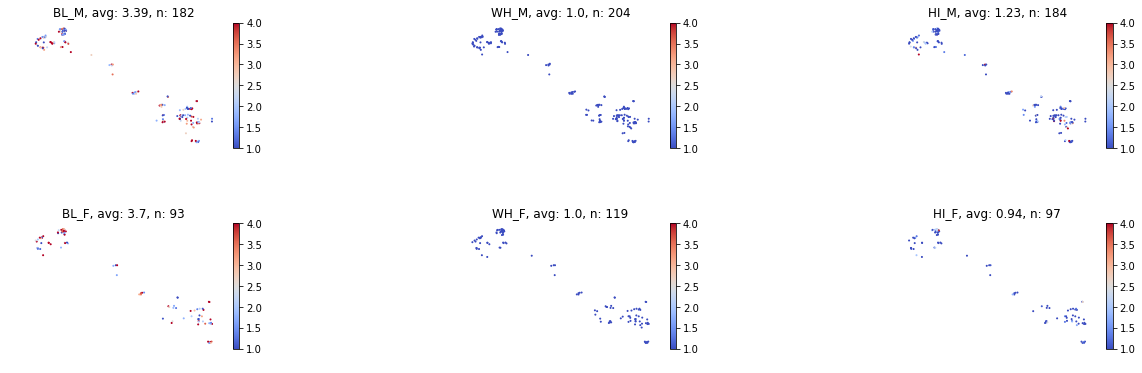

In [9]:
data = calculate_likelyhood_comparisons(df, 'SCH_DISCWODIS_MULTOOS', comparison_race='WH')  # "more than one out of school suspension"
calculation = 'LH_COMPARED_TO_WH_FOR' 
measure = 'SCH_DISCWODIS_MULTOOS'
plot_measure_accross_all_demographics(data, calculation, measure, bounds=[1, 4])

#### Notes:
- TO DO: show the CONVERSE: which schools are excluded becuase they don't have a significant enough number of a race?

# Question 2: What impact have "Zero-tolerance" policies had on expulsion?

All analysis look at "students without disabilities expelled on zero tolerance policy".

### Zero Tolerance policies impact 2% of white students, but about *4% and 5%* of black and latino students, respectively, for schools who gave out at least one Zero Tolerance based expulsion for that demographic.

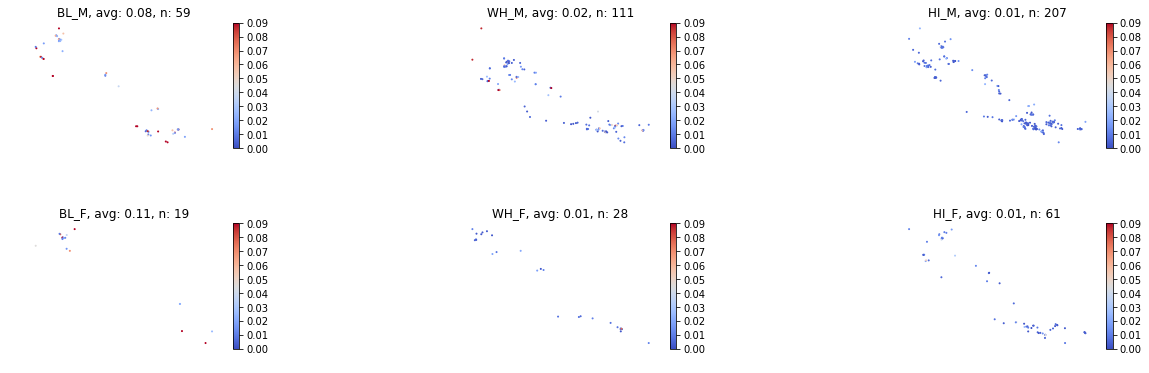

In [10]:
measure = 'SCH_DISCWODIS_EXPZT'
calculation = 'PERCENT_AFFECTED'
data = calculate_likelyhood_comparisons(df, measure, lower_bound=1)
plot_measure_accross_all_demographics(data, calculation, measure, bounds=[0,0.09])

# Question 3: Does the proportion of Campus Counselors (psychologists) vs Campus Police Officers correlate with suspensions? 

### Data notes:

1. It's possible to have *fractional* staff recorded if they are not full-time.

2. __A Data entry, system-level error__ on the form filled in by schools caused only __22,000 schools (after corrections 25000)__ to correctly enter the number of Law Enforcement Officers on campus. Where this system error occurred, the value is `-9`. Due this fact, there are only __17,500 schools with *both* Police and Counselor counts__. We'll do *investigate Juvenile Justice Facilities seperately*: first, because we'd expect different counselor and police presence there, but second because none of them actually recorded the number of police.

3. #### Where are the police data?
Notably, none of the 608 Juvenile Justice facilities which have a count enterered for Police officers. This may be because the police staff at JJ facilities do not map to the categories on the survey.

We *could* try to use __Security Guards__ as a proxy for Police. However, only 64 of the 608 JJ facilities have data for both Counselors *and* Security Guards, so we've removed all JJ schools from the following analysis.


In [12]:
POLICE = 'SCH_FTESECURITY_LEO'
COUNSELORS = 'SCH_FTESERVICES_PSY'
SECURITY_GUARDS = 'SCH_FTESECURITY_GUA'

SUSPENSIONS = 'TOTAL_SUSPENSIONS'


def plot_ratio_to_students_of(
                data=crdc_data,
                x_name=POLICE,
                y_name=COUNSELORS,
                xlabel=None,
                ylabel=None,
                xlim=None,
                ylim=None,
                dot_size=0.5,
                show_hist=False
):
    # Filter out any negative numbers, which signal data errors
    schools_with_correctly_documented_staff = (data[[y_name, x_name]] >= 0).all(axis='columns')
    staff_df = data.loc[schools_with_correctly_documented_staff,]

    # Get ratio to student population
    total_pop = staff_df['TOT_ENR_M'] + staff_df['TOT_ENR_F']
    staff_to_students_df = pd.DataFrame()
    staff_to_students_df[y_name] = staff_df[y_name] / total_pop
    staff_to_students_df[x_name] = staff_df[x_name] / total_pop

    # Total Suspensions, for dot coloring
    staff_to_students_df[SUSPENSIONS] = staff_df[['TOT_DISCWODIS_MULTOOS_M', 'TOT_DISCWODIS_MULTOOS_F']].sum(
        axis='columns') / total_pop

    # Remove anomalies
    staff_to_students_df = staff_to_students_df[staff_to_students_df[SUSPENSIONS] > 0]

    plt.scatter(x=staff_to_students_df[x_name], y=staff_to_students_df[y_name], alpha=0.9, s=dot_size,
                c=staff_to_students_df[SUSPENSIONS], cmap='coolwarm')
    plt.clim(0, 0.05)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(f'{xlabel} vs {ylabel}, color=Long Term Suspension Percentage, n={len(staff_to_students_df)}')
    plt.colorbar()
    axes = plt.gca()
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

    plt.show()

    if show_hist:
        # Hist of x axis
        plot_hist(staff_to_students_df, x_name, xlabel)
        # Hist of y axis
        plot_hist(staff_to_students_df, y_name, ylabel)

    return staff_to_students_df


def plot_hist(data, name, label, x_range=[0, 0.008], y_range=[None, None]):
    plt.hist(data[name], range=x_range, bins=100)
    plt.xlabel(label)
    plt.ylabel('Number of Schools')
    plt.title(f'Distribution of {label}, n={len(data)}, mean={round(data[name].mean(), 3)}')
    plt.grid(True)
    plt.show()
    return


# Non Juvenile Justice Schools: 
## *Long Term Suspensions correlate with Police Presence*

Plotting Campus Police against Campus Counselors per student, and color schools by  we see a a hotspot of suspensions at shcools with low-counselor levels and high police levels.

You can also see how __schools seem to hire with a predetermined ratio in mind__: consistent ratio lines jut outward, most notably one marking the a 1-to-1 ratio.

This supports existing intution in the "School to Prison Pipeline" concept -- *schools with high suspension rates confront troubled kids with police with higher likelyhood than trained counselors*. However, __it remains unclear if high levels of suspension-worthy activity triggered hiring more Police, or if increased Police (and a lack of counseling) escalate suspension counts.__ 

Which leads us to two questions we can investigate: __do Police correlate positively *alone* with suspensions, or does it worsen when mixed with low counseling?__

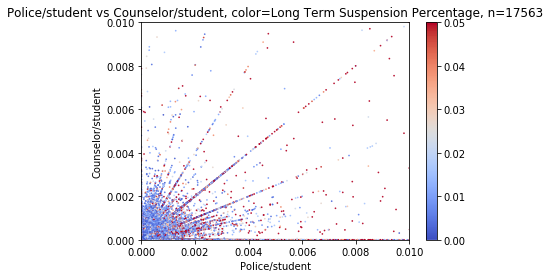

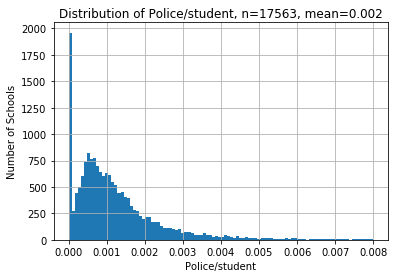

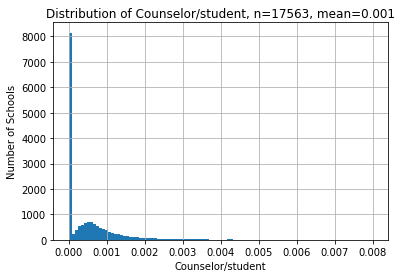

In [14]:
staff_to_students_df = plot_ratio_to_students_of( 
    x_name=POLICE, 
    y_name=COUNSELORS, 
    xlabel='Police/student', 
    ylabel='Counselor/student', 
    xlim=[0, 0.01], 
    ylim=[0, 0.01],
    show_hist=True
)

## *Does lack of counselors alone account for increased suspensions?*

### Interestingly, Schools with the recommended ration of Counselors to Students actually have *3x the rate of suspensions*

This, of course, may result from schools with a high rates of suspensions and misbehaviour attempting to mediate rates via increased counselors. But further research is required.

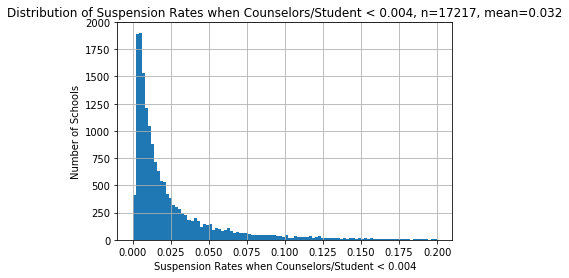

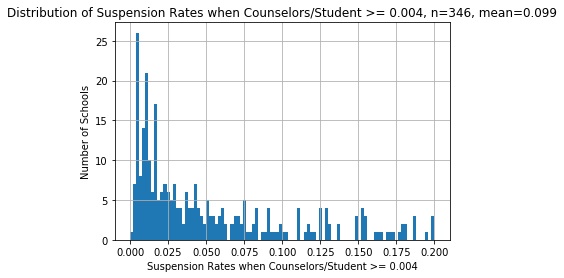

In [160]:
insufficient_counselors = staff_to_students_df[staff_to_students_df[COUNSELORS] < 0.004]
plot_hist(insufficient_counselors, SUSPENSIONS, label=f'Suspension Rates when Counselors/Student < 0.004', x_range=[0, 0.2])

sufficient_counselors = staff_to_students_df[staff_to_students_df[COUNSELORS] >= 0.004]
plot_hist(sufficient_counselors, SUSPENSIONS, label=f'Suspension Rates when Counselors/Student >= 0.004', x_range=[0, 0.2])


## *Does high levels of Police alone correlate with increased suspensions?*

### Here, results line up predictably with the STTP: Schools with the Police/Student ration >= 0.004 have actually have *6x the rate of suspensions* of those who had less police presence

This, of course, may result from schools with a high rates of suspensions and misbehaviour attempting to mediate rates via increased counselors. But further research is required.

TODO: REWRITE

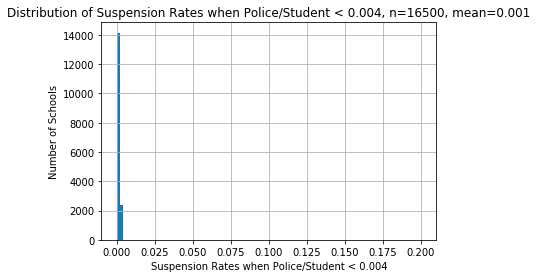

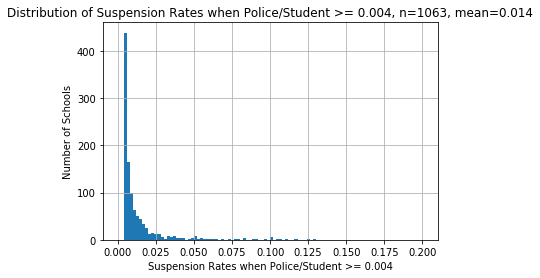

In [15]:

low_police = staff_to_students_df[staff_to_students_df[POLICE] < 0.004]
plot_hist(low_police, POLICE, label=f'Suspension Rates when Police/Student < 0.004', x_range=[0, 0.2])

high_police = staff_to_students_df[staff_to_students_df[POLICE] >= 0.004]
plot_hist(high_police, POLICE, label=f'Suspension Rates when Police/Student >= 0.004', x_range=[0, 0.2])

## Q:*What's the correlation with having more Police than Counselors?*
## A: A 2x increase in suspensions: from 0.001 to 0.002

to do: try looking using above/below means or median
FOR FUTURE: compare quartiles

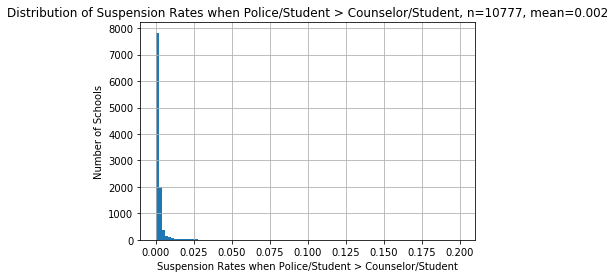

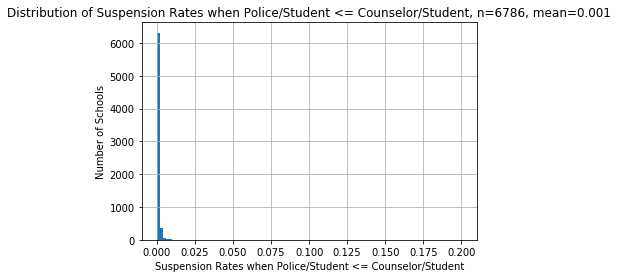

In [148]:
more_police = staff_to_students_df[staff_to_students_df[COUNSELORS] < staff_to_students_df[POLICE]]
plot_hist(more_police, POLICE, label=f'Suspension Rates when Police/Student > Counselor/Student', x_range=[0, 0.2])

less_police = staff_to_students_df[staff_to_students_df[COUNSELORS] >= staff_to_students_df[POLICE]]
plot_hist(less_police, POLICE, label=f'Suspension Rates when Police/Student <= Counselor/Student', x_range=[0, 0.2])

# Future questions to investigate

### Digging deeper into Zero Tolerance Policies
With proper data on *which schools implement zero-tolerance* (rather than just knowing which schools have given at least one suspension via the policies), we could more accurately measure the impact of these policies.

*Does zero-tolerance policy adoption correlate with other factors? Do ZT policy schools have a higher rate in general of expulsions?*


## *By introducing previous years data, what trends do we see in critical STTP measures?*
Particularly of interest, can we see schools increasing police or at the cost of counselors? And does that impact change in suspension rates?

Further, we could takes differences between years to identify schools underwent large changes, and investigate them further for signs of the cuase.

## Expanding my analysis to more demographic and discipline categories
More obviously, this investigation looked only at students from three races without disabilities and in terms of long term suspensions. More rigorous analsysis would include more expansive demographics as well as comparison against and aggregation with short term suspensions.

## Incorperate Socio-Economic Status and Test Scores
[The NYT's Upshot did a data vis article comparing race, academic performance, and income](https://www.nytimes.com/interactive/2016/04/29/upshot/money-race-and-success-how-your-school-district-compares.html) utilizing the Stanford Education Data Archive (SEDA). The positive trend of wealth and performance were stunning, as were how wealth seems not to nuetralize the race-based gaps in achievement-- *do these hold for discipline as well?*